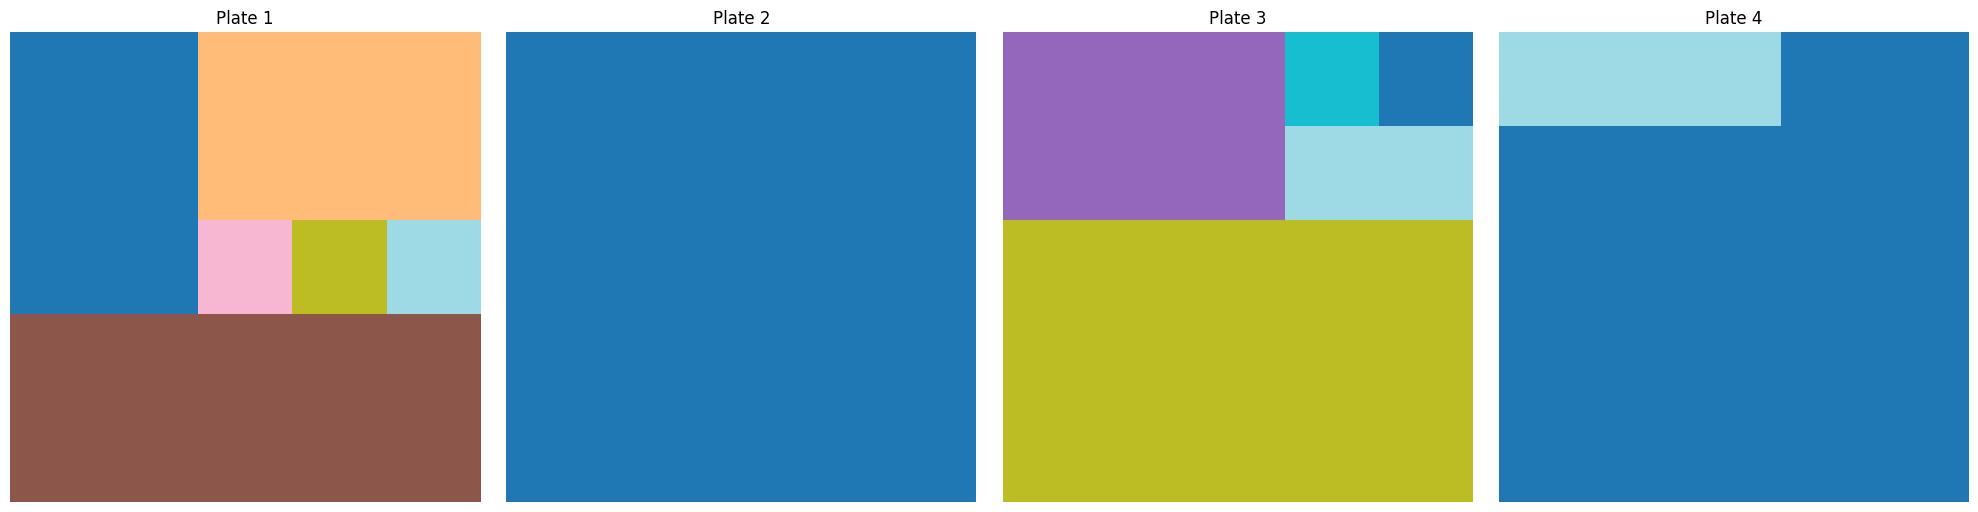

Plate 1:
+---+---+---+---+---+
| 1 | 1 | 2 | 2 | 2 |
+---+---+---+---+---+
| 1 | 1 | 2 | 2 | 2 |
+---+---+---+---+---+
| 1 | 1 | 5 | 6 | 7 |
+---+---+---+---+---+
| 4 | 4 | 4 | 4 | 4 |
+---+---+---+---+---+
| 4 | 4 | 4 | 4 | 4 |
+---+---+---+---+---+


Plate 2:
+---+---+---+---+---+
| 3 | 3 | 3 | 3 | 3 |
+---+---+---+---+---+
| 3 | 3 | 3 | 3 | 3 |
+---+---+---+---+---+
| 3 | 3 | 3 | 3 | 3 |
+---+---+---+---+---+
| 3 | 3 | 3 | 3 | 3 |
+---+---+---+---+---+
| 3 | 3 | 3 | 3 | 3 |
+---+---+---+---+---+


Plate 3:
+---+---+---+----+----+
| 4 | 4 | 4 | 9  | 0  |
+---+---+---+----+----+
| 4 | 4 | 4 | 10 | 10 |
+---+---+---+----+----+
| 8 | 8 | 8 | 8  | 8  |
+---+---+---+----+----+
| 8 | 8 | 8 | 8  | 8  |
+---+---+---+----+----+
| 8 | 8 | 8 | 8  | 8  |
+---+---+---+----+----+


Plate 4:
+----+----+----+---+---+
| 11 | 11 | 11 | 0 | 0 |
+----+----+----+---+---+
| 0  | 0  | 0  | 0 | 0 |
+----+----+----+---+---+
| 0  | 0  | 0  | 0 | 0 |
+----+----+----+---+---+
| 0  | 0  | 0  | 0 | 0 |
+----+----

In [ ]:
import numpy as np
import heapq
import matplotlib
import matplotlib.pyplot as plt
from tabulate import tabulate


class PlatesManager:
    def __init__(self, plate_width, plate_height):
        """
        Initializes the PlatesManager with the dimensions for the plates.
        """
        self.plate_width = plate_width
        self.plate_height = plate_height
        self.plates = []
        self.available_slots = []  # Priority queue to track available slots
        
    def calculate_cost(self, plates):
        """
        Calculate the cost of the plate arrangement based on the number of plates used
        and the unused space on each plate. Fewer plates and less unused space is cheaper.
        """
        num_plates = len(plates)
        unused_space = 0  # Track unused space in each plate
        
        for plate in plates:
            unused_space += np.count_nonzero(plate == 0)  # Count empty spaces (zeroes) on the plate

        # Cost can be defined as the number of plates plus unused space
        # You could adjust this cost function based on your specific requirements
        cost = num_plates*(self.plate_width*self.plate_height) + unused_space
        return cost
    
    def update_heap(self):
        """
        Rebuild the heap from the available slots and their current available space.
        This avoids unnecessary heap operations during minor updates.
        """
        if not self.dirty_slots:
            return  # No dirty slots to update
        
        # Rebuild the heap from the slot map
        self.available_slots = [(space, idx) for idx, space in self.slot_map.items()]
        heapq.heapify(self.available_slots)
        self.dirty_slots.clear()

    def create(self):
        """
        Create an initial plate with the specified size.
        """
        initial_plate = np.zeros((self.plate_height, self.plate_width), dtype=int)
        self.plates.append(initial_plate)
        # Push the initial plate into the available slots heap (with priority on available space)
        heapq.heappush(self.available_slots, (self.plate_width * self.plate_height, 0))

    def find_and_place_rectangle(self, rect_width, rect_height, fill_value, rotate=False):
        """
        Try to place a rectangle on the first available plate or split it if it's too large.
        """         
        cost=0
        order=[]
        # Handle large rectangles that might require splitting
        if rect_width > self.plate_width or rect_height > self.plate_height:
            sub_rectangles = self.split_large_rectangle(rect_width, rect_height)
            cost, order=self.place_sub_rectangles(sub_rectangles, fill_value)
        else:
        # If the rectangle fits within the plate size, proceed as normal
            cost, order=self.place_rectangle_on_existing_plates(rect_width, rect_height, fill_value)

    
        if rotate:
            rect_width, rect_height = rect_height, rect_width    
            if rect_width > self.plate_width or rect_height > self.plate_height:
                sub_rectangles = self.split_large_rectangle(rect_width, rect_height)
                costR, orderR=self.place_sub_rectangles(sub_rectangles, fill_value)
            else:
            # If the rectangle fits within the plate size, proceed as normal
                costR, orderR=self.place_rectangle_on_existing_plates(rect_width, rect_height, fill_value)        
            if(costR<cost):
                cost=costR
                order=orderR
        #Update heapq
        
        self.plates=order
        return cost
    
    def split_large_rectangle(self, rect_width, rect_height):
        """
        Splits the large rectangle into smaller sub-rectangles.
        """
        sub_rectangles = []
        
        # Try splitting along the width or height of the plate
        while rect_width > self.plate_width or rect_height > self.plate_height:
            if rect_width > self.plate_width:
                sub_rectangles.append((self.plate_width, rect_height))
                rect_width -= self.plate_width
            elif rect_height > self.plate_height:
                sub_rectangles.append((rect_width, self.plate_height))
                rect_height -= self.plate_height

        # Add the final remaining part
        if rect_width <= self.plate_width and rect_height <= self.plate_height:
            sub_rectangles.append((rect_width, rect_height))

        return sub_rectangles

    def place_sub_rectangles(self, sub_rectangles, fill_value):
        """
        Place the sub-rectangles onto the plates, reusing space or creating new plates as necessary.
        This version does not modify self.plates, instead returns a new list of plates with updated placements.
        """
        new_plates = [plate.copy() for plate in self.plates]  # Make a copy of the current plates
        available_slots_copy = list(self.available_slots)  # Copy the available slots list
        
        for sub_width, sub_height in sub_rectangles:
            placed = False
            while not placed:
                # Try placing on an existing plate first
                if available_slots_copy:
                    available_space, plate_index = heapq.heappop(available_slots_copy)
                    plate = new_plates[plate_index]
                    rows, cols = plate.shape
                    for i in range(rows - sub_height + 1):
                        for j in range(cols - sub_width + 1):
                            if np.all(plate[i:i + sub_height, j:j + sub_width] == 0):  # Slot found
                                plate[i:i + sub_height, j:j + sub_width] = fill_value
                                # Update available space tracking
                                new_available_space = available_space - (sub_width * sub_height)
                                heapq.heappush(available_slots_copy, (new_available_space, plate_index))
                                placed = True
                                break
                    if placed:
                        break
                if not placed:
                    # If no space found, create a new plate
                    new_plate = np.zeros((self.plate_height, self.plate_width), dtype=int)
                    new_plates.append(new_plate)
                    heapq.heappush(available_slots_copy, (self.plate_width * self.plate_height, len(new_plates) - 1))
                    new_plate[:sub_height, :sub_width] = fill_value
                    placed = True
                    
        cost=self.calculate_cost(new_plates)
        return cost, new_plates  # Return the new plates list


    def place_rectangle_on_existing_plates(self, rect_width, rect_height, fill_value):
        """
        Tries to place a regular rectangle on existing plates, without modifying the original plates.
        """
        new_plates = [plate.copy() for plate in self.plates]  # Create a copy of self.plates

        for plate in new_plates:
            rows, cols = plate.shape
            for i in range(rows - rect_height + 1):
                for j in range(cols - rect_width + 1):
                    if np.all(plate[i:i + rect_height, j:j + rect_width] == 0):  # Slot found
                        plate[i:i + rect_height, j:j + rect_width] = fill_value
                        cost=self.calculate_cost(new_plates)
                        return cost, new_plates  # Return the copy of plates

        # If no space is found, create a new plate with original dimensions
        new_plate = np.zeros((self.plate_height, self.plate_width), dtype=int)
        new_plates.append(new_plate)
        new_plate[:rect_height, :rect_width] = fill_value
        
        cost=self.calculate_cost(new_plates)
        return cost, new_plates  # Return the copy of plates

    def print_plates(self):
        """
        Prints the list of plates in a nicely formatted table.
        """
        for i, plate in enumerate(self.plates):
            print(f"Plate {i + 1}:")
            print(tabulate(plate, tablefmt="grid", numalign="center", stralign="center"))
            print("\n")

    def plot_plates(self):
        """
        Visualizes the list of plates using matplotlib with color-coded rectangles.
        """        
        num_plates = len(self.plates)
        
        fig, axes = plt.subplots(1, num_plates, figsize=(5 * num_plates, 5))
        if num_plates == 1:
            axes = [axes]
        
        cmap = matplotlib.colormaps['tab20']
        color_map = {i: cmap(i / len(self.plates)) for i in range(len(self.plates))}

        for i, plate in enumerate(self.plates):
            ax = axes[i]
            ax.imshow(plate, cmap=cmap, interpolation='nearest')
            ax.set_title(f"Plate {i + 1}")
            ax.grid(True)
            ax.set_xticks([])  # Hide x ticks
            ax.set_yticks([])  # Hide y ticks
            ax.axis('off')

        plt.tight_layout()
        plt.show()


# Example usage:
if __name__ == "__main__":
    plates_manager = PlatesManager(5, 5)
    plates_manager.create()  # Create initial plate
    plates_manager.find_and_place_rectangle(2, 3, 1)  # Place a 2x3 rectangle with value 1
    plates_manager.find_and_place_rectangle(3, 2, 2)  # Place a 3x2 rectangle with value 2
    plates_manager.find_and_place_rectangle(5, 5, 3)  # Place a 5x5 rectangle with value 3
    plates_manager.find_and_place_rectangle(8, 2, 4)  # Place a 5x5 rectangle with value 3
    for i in range(3):
            plates_manager.find_and_place_rectangle(1, 1, 5+i)  # Place a 5x5 rectangle with value 3
    plates_manager.find_and_place_rectangle(3, 5, 8,True)  # Place a 5x5 rectangle with value 3
    for i in range(3):
        plates_manager.find_and_place_rectangle(1+i, 1, 9+i,True)  # Place a 5x5 rectangle with value 3
        
    plates_manager.plot_plates()  # Plot the plates
    plates_manager.print_plates()  # Print the plates in table format
    print(plates_manager.calculate_cost(plates_manager.plates))


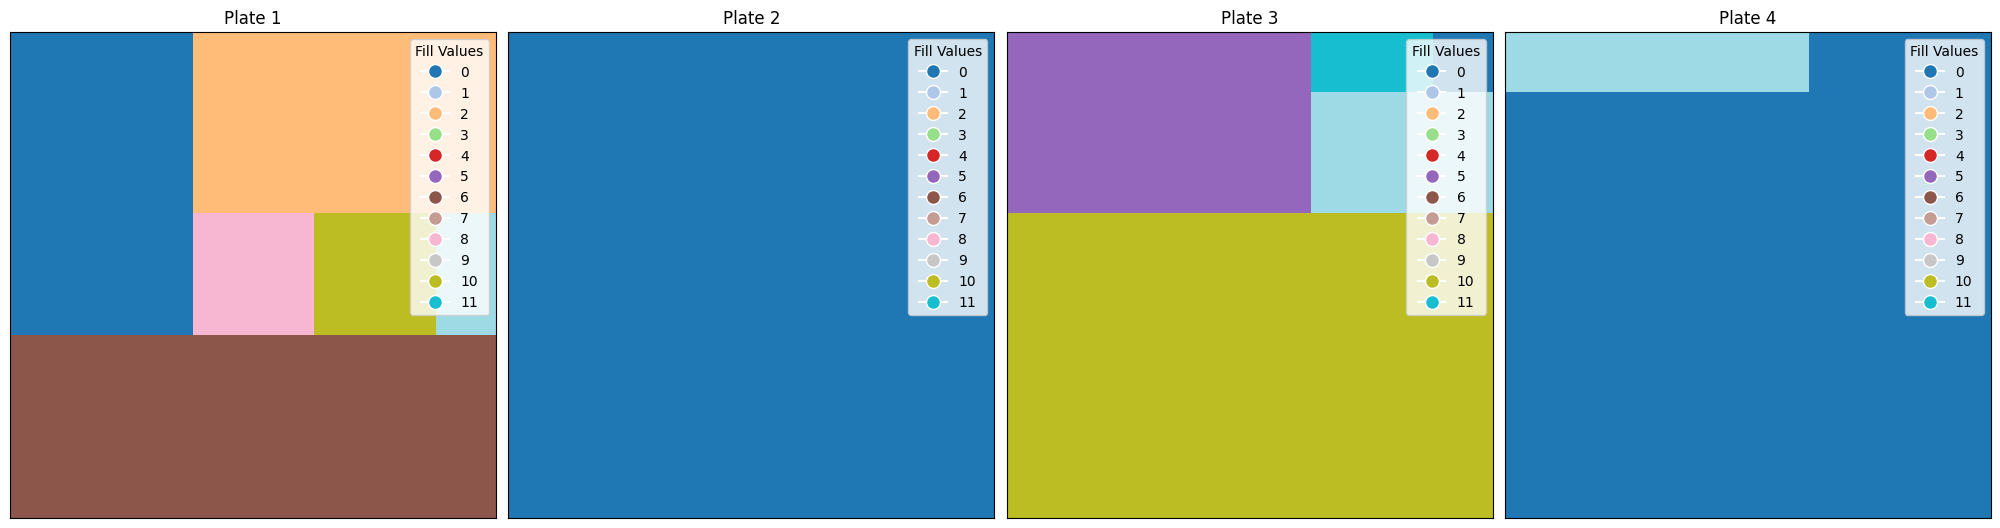

Plate 1:
+---+---+---+---+---+
| 1 | 1 | 2 | 2 | 2 |
+---+---+---+---+---+
| 1 | 1 | 2 | 2 | 2 |
+---+---+---+---+---+
| 1 | 1 | 5 | 6 | 7 |
+---+---+---+---+---+
| 4 | 4 | 4 | 4 | 4 |
+---+---+---+---+---+
| 4 | 4 | 4 | 4 | 4 |
+---+---+---+---+---+


Plate 2:
+---+---+---+---+---+
| 3 | 3 | 3 | 3 | 3 |
+---+---+---+---+---+
| 3 | 3 | 3 | 3 | 3 |
+---+---+---+---+---+
| 3 | 3 | 3 | 3 | 3 |
+---+---+---+---+---+
| 3 | 3 | 3 | 3 | 3 |
+---+---+---+---+---+
| 3 | 3 | 3 | 3 | 3 |
+---+---+---+---+---+


Plate 3:
+---+---+---+----+----+
| 4 | 4 | 4 | 9  | 0  |
+---+---+---+----+----+
| 4 | 4 | 4 | 10 | 10 |
+---+---+---+----+----+
| 8 | 8 | 8 | 8  | 8  |
+---+---+---+----+----+
| 8 | 8 | 8 | 8  | 8  |
+---+---+---+----+----+
| 8 | 8 | 8 | 8  | 8  |
+---+---+---+----+----+


Plate 4:
+----+----+----+---+---+
| 11 | 11 | 11 | 0 | 0 |
+----+----+----+---+---+
| 0  | 0  | 0  | 0 | 0 |
+----+----+----+---+---+
| 0  | 0  | 0  | 0 | 0 |
+----+----+----+---+---+
| 0  | 0  | 0  | 0 | 0 |
+----+----

In [11]:
import numpy as np
import heapq
import matplotlib
import matplotlib.pyplot as plt
from tabulate import tabulate

class PlatesManager:
    def __init__(self, plate_width, plate_height):
        """
        Initializes the PlatesManager with the dimensions for the plates.
        """
        self.plate_width = plate_width
        self.plate_height = plate_height
        self.plates = []
        self.available_slots = []  # Priority queue to track available slots
        
    def calculate_cost(self, plates):
        """
        Calculate the cost of the plate arrangement based on the number of plates used
        and the unused space on each plate. Fewer plates and less unused space is cheaper.
        """
        num_plates = len(plates)
        unused_space = sum(np.count_nonzero(plate == 0) for plate in plates)  # Summing empty spaces in all plates

        # Cost can be defined as the number of plates plus unused space
        cost = num_plates * (self.plate_width * self.plate_height) + unused_space
        return cost
    
    def create(self):
        """
        Create an initial plate with the specified size.
        """
        initial_plate = np.zeros((self.plate_height, self.plate_width), dtype=int)
        self.plates.append(initial_plate)
        heapq.heappush(self.available_slots, (self.plate_width * self.plate_height, 0))

    def find_and_place_rectangle(self, rect_width, rect_height, fill_value, rotate=False):
        """
        Try to place a rectangle on the first available plate or split it if it's too large.
        """         
        cost = float('inf')
        order = self.plates  # Keep track of the best plate arrangement

        # Function to attempt placing the rectangle
        def try_placing(w, h):
            nonlocal cost, order
            if w > self.plate_width or h > self.plate_height:
                sub_rectangles = self.split_large_rectangle(w, h)
                new_cost, new_order = self.place_sub_rectangles(sub_rectangles, fill_value)
            else:
                new_cost, new_order = self.place_rectangle_on_existing_plates(w, h, fill_value)
            
            if new_cost < cost:
                cost = new_cost
                order = new_order

        try_placing(rect_width, rect_height)
        if rotate:
            try_placing(rect_height, rect_width)
        
        self.plates = order  # Update the plates to the optimal arrangement
        return cost

    def split_large_rectangle(self, rect_width, rect_height):
        """
        Splits the large rectangle into smaller sub-rectangles.
        """
        sub_rectangles = []
        
        # Try splitting along the width or height of the plate
        while rect_width > self.plate_width or rect_height > self.plate_height:
            if rect_width > self.plate_width:
                sub_rectangles.append((self.plate_width, rect_height))
                rect_width -= self.plate_width
            elif rect_height > self.plate_height:
                sub_rectangles.append((rect_width, self.plate_height))
                rect_height -= self.plate_height

        # Add the final remaining part
        if rect_width <= self.plate_width and rect_height <= self.plate_height:
            sub_rectangles.append((rect_width, rect_height))

        return sub_rectangles

    def place_sub_rectangles(self, sub_rectangles, fill_value):
        """
        Place the sub-rectangles onto the plates, reusing space or creating new plates as necessary.
        """
        new_plates = [plate.copy() for plate in self.plates]
        available_slots_copy = list(self.available_slots)  # Copy the available slots list
        
        for sub_width, sub_height in sub_rectangles:
            placed = False
            while not placed:
                if available_slots_copy:
                    available_space, plate_index = heapq.heappop(available_slots_copy)
                    plate = new_plates[plate_index]
                    for i in range(plate.shape[0] - sub_height + 1):
                        for j in range(plate.shape[1] - sub_width + 1):
                            if np.all(plate[i:i + sub_height, j:j + sub_width] == 0):  # Slot found
                                plate[i:i + sub_height, j:j + sub_width] = fill_value
                                heapq.heappush(available_slots_copy, (available_space - (sub_width * sub_height), plate_index))
                                placed = True
                                break
                    if placed:
                        break
                if not placed:
                    new_plate = np.zeros((self.plate_height, self.plate_width), dtype=int)
                    new_plates.append(new_plate)
                    heapq.heappush(available_slots_copy, (self.plate_width * self.plate_height, len(new_plates) - 1))
                    new_plate[:sub_height, :sub_width] = fill_value
                    placed = True
                    
        cost = self.calculate_cost(new_plates)
        return cost, new_plates

    def place_rectangle_on_existing_plates(self, rect_width, rect_height, fill_value):
        """
        Tries to place a regular rectangle on existing plates, without modifying the original plates.
        """
        new_plates = [plate.copy() for plate in self.plates]

        for plate in new_plates:
            for i in range(plate.shape[0] - rect_height + 1):
                for j in range(plate.shape[1] - rect_width + 1):
                    if np.all(plate[i:i + rect_height, j:j + rect_width] == 0):  # Slot found
                        plate[i:i + rect_height, j:j + rect_width] = fill_value
                        return self.calculate_cost(new_plates), new_plates  # Return immediately once placed

        new_plate = np.zeros((self.plate_height, self.plate_width), dtype=int)
        new_plates.append(new_plate)
        new_plate[:rect_height, :rect_width] = fill_value
        
        return self.calculate_cost(new_plates), new_plates

    def print_plates(self):
        """
        Prints the list of plates in a nicely formatted table.
        """
        for i, plate in enumerate(self.plates):
            print(f"Plate {i + 1}:")
            print(tabulate(plate, tablefmt="grid", numalign="center", stralign="center"))
            print("\n")

    def plot_plates(self):
        """
        Visualizes the list of plates using matplotlib with color-coded rectangles and adds a legend.
        """
        num_plates = len(self.plates)
        
        # Adjust the number of subplots based on the number of plates
        fig, axes = plt.subplots(1, num_plates, figsize=(5 * num_plates, 5))
        
        if num_plates == 1:
            axes = [axes]

        # Create a dynamic color map for the unique fill values
        unique_values = np.unique(np.concatenate([plate.flatten() for plate in self.plates]))
        cmap = matplotlib.colormaps['tab20']  # Use a colormap with enough colors for each unique value
        color_map = {val: cmap(i / len(unique_values)) for i, val in enumerate(unique_values)}

        # Create a list of labels for the legend (fill_value -> color)
        handles = []
        labels = []
        for val, color in color_map.items():
            # Create a handle (patch) for each unique value
            handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
            handles.append(handle)
            labels.append(str(val))  # Use the fill_value as the label

        for i, plate in enumerate(self.plates):
            ax = axes[i]
            ax.imshow(plate, cmap=cmap, interpolation='nearest')

            # Add the legend to the plot
            ax.legend(handles, labels, title="Fill Values", loc="upper right", bbox_to_anchor=(1, 1))

            ax.set_title(f"Plate {i + 1}")
            ax.set_xlim(0, plate.shape[1] - 1)
            ax.set_ylim(plate.shape[0] - 1, 0)
            ax.grid(True, which='both', color='black', linestyle='-', linewidth=2)
            ax.set_xticks([0, plate.shape[1] - 1])
            ax.set_yticks([0, plate.shape[0] - 1])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.axis('on')
            ax.set_aspect('equal', adjustable='box')

        plt.tight_layout(pad=0.5)
        plt.show()

# Example usage:
if __name__ == "__main__":
    plates_manager = PlatesManager(5, 5)
    plates_manager.create()  # Create initial plate
    plates_manager.find_and_place_rectangle(2, 3, 1)  # Place a 2x3 rectangle with value 1
    plates_manager.find_and_place_rectangle(3, 2, 2)  # Place a 3x2 rectangle with value 2
    plates_manager.find_and_place_rectangle(5, 5, 3)  # Place a 5x5 rectangle with value 3
    plates_manager.find_and_place_rectangle(8, 2, 4)  # Place a 5x5 rectangle with value 3
    for i in range(3):
            plates_manager.find_and_place_rectangle(1, 1, 5+i)  # Place a 5x5 rectangle with value 3
    plates_manager.find_and_place_rectangle(3, 5, 8,True)  # Place a 5x5 rectangle with value 3
    for i in range(3):
        plates_manager.find_and_place_rectangle(1+i, 1, 9+i,True)  # Place a 5x5 rectangle with value 3
        
    plates_manager.plot_plates()  # Plot the plates
    plates_manager.print_plates()  # Print the plates in table format
    print(plates_manager.calculate_cost(plates_manager.plates))
